In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [130]:
def foo(lastKDays):
    dfs = []
    splits = 6
    for i in range(splits):
        for j in range(splits-1):
            gp = np.load(f"../exp2/src/results/{lastKDays}/final_gp/{i}_{j}/final_rmse.npy")
            qbc = np.load(f"../exp2/src/results/{lastKDays}/final_qbc/{i}_{j}/final_rmse.npy")
            qbc_rd = np.load(f"../exp2/src/results/{lastKDays}/final_random_qbc/{i}_{j}/final_rmse.npy")
            gp_rd = np.load(f"../exp2/src/results/{lastKDays}/final_random_gp/{i}_{j}/final_rmse.npy")

#             print(qbc.shape)            
#             print(qbc_rd.shape)
#             print(gp.shape)            
#             print(gp_rd.shape)
            
            for reg, temp in zip(["gp", "qbc"], [gp, qbc]):
                store = {
                    'kout': [i]*len(list(temp)),
                    'kin': [j]*len(list(temp)),
                    'reg': [reg] * len(list(temp)),
                    "day": [i for i in range(len(temp))],
                    "rmse": temp,
                    "std": [0]*len(list(temp))
                }
                tempdf = pd.DataFrame(store)
                dfs.append(tempdf)
            for reg, temp in zip(["qbc_rd", "gp_rd"], [qbc_rd, gp_rd]):
                store = {
                    'kout': [i]*temp.shape[1],
                    'kin': [j]*temp.shape[1],
                    'reg': [reg] * temp.shape[1],
                    "day": [i for i in range(temp.shape[1])],
                    "rmse": temp[:5].mean(axis=0),
                    "std": temp[:5].std(axis=0)
                }
#                 print ([len(k) for k in store.values()])
                tempdf = pd.DataFrame(store)
                dfs.append(tempdf)
                
    return pd.concat(dfs)

In [131]:
df = []
for lastKDays in [10, 20, 30]:
    df.append(foo(lastKDays))
df = pd.concat(df)
df.head()

,kout,kin,reg,day,rmse,std
0,0,0,gp,0,4.098668,0.0
1,0,0,gp,1,6.443400,0.0
2,0,0,gp,2,5.249915,0.0
3,0,0,gp,3,4.046290,0.0
4,0,0,gp,4,6.314935,0.0


In [ ]:
df.groupby(["kout", "kin", "day"]).idmin()

In [ ]:
splits = 6
for kout in range(splits):
    for kin in range(splits-1):
        

In [127]:
# for i in range(6):
#     for j in range(5):
#         tmp = df[df['i']==i]
#         tmp = tmp[tmp['j']==j]
# #         sns.lineplot(data=tmp, x="X", y="Y", hue="reg")
#         print (tmp.groupby("reg").mean())
# #         plt.show()

In [128]:
df.groupby("reg").mean()

,kout,kin,X,rmse,std
reg,,,,,
gp,2.5,2.0,172.596339,20.350975,0.000000
gp_rd,2.5,2.0,172.596339,23.373950,8.727330
qbc,2.5,2.0,172.596339,22.814577,0.000000
qbc_rd,2.5,2.0,172.596339,24.066029,6.467782


In [ ]:
gp = np.load("../exp2/src/results/20/final_gp/0_0/final_rmse.npy")
qbc = np.load("../exp2/src/results/20/final_qbc/0_0/final_rmse.npy")
qbc_rd = np.load("../exp2/src/results/20/final_random_qbc/0_0/final_rmse.npy")[:5].mean(axis=0)
gp_rd = np.load("../exp2/src/results/20/final_random_gp/0_0/final_rmse.npy").mean(axis=0)


In [ ]:
gp = gp[gp!=0]
qbc = qbc[qbc!=0]

In [81]:
gp[1], gp_rd[1], qbc[0], qbc_rd[0] 

(22.367600909296137,
 19.846230717294098,
 7.1551148292844955,
 7.1551148292844955)

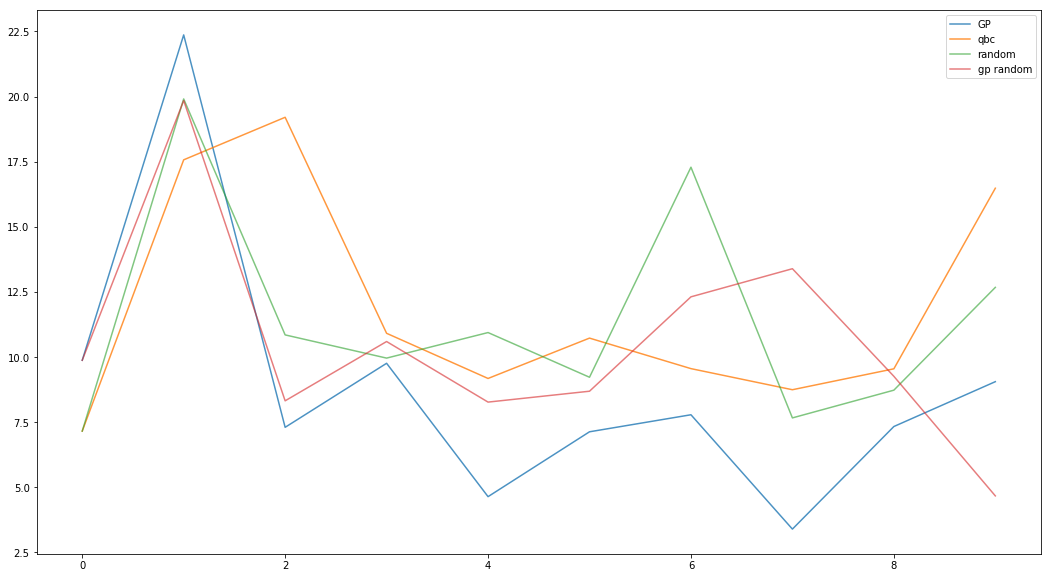

In [82]:
plt.figure(figsize=(18, 10))
plt.plot(gp[:10], alpha= 0.8, label="GP")
plt.plot(qbc[:10], alpha = 0.8, label="qbc")
plt.plot(qbc_rd[:10], alpha = 0.6, label='random')
plt.plot(gp_rd[:10], alpha = 0.6, label='gp random')

plt.legend()
# plt.plot(qbc_rd)

In [6]:
np.load("../exp2/src/results/20/final_gp/0_0/final_rmse.npy")
gp.mean(), qbc.mean()

(16.87702705582097, 21.959137708694254)

In [16]:
mean = qbc_rd.mean(axis = 0)
mean = mean[mean!=0]

In [ ]:
    for j in range(1,31,5):
        plt.axvline(j,ls='--',color='k',lw=0.5)
#     format_axes(plt.gca())
#     plt.errorbar([i for i in range(32)],random_final,yerr=stddev,marker='.',label='Random Sampling')


In [29]:
gp.shape

(346,)